In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import pandas as pd
import time

In [15]:
# 농산물 코드표 업로드 
col_data = pd.read_excel('농축수산물 품목 및 등급 코드표_품종별.xlsx', sheet_name="품종코드", dtype={0: str, 1: str}, usecols=[1, 2], header=1)

# 결과 확인
itemcode_list = col_data.iloc[:, 0].tolist()
kindcode_list = col_data.iloc[:, 1].tolist()
print(len(itemcode_list), len(kindcode_list))

40 40


In [16]:
# Open API 로 데이터 불러오기 & data frame화
def fetch_kamis_data(start_day: str, end_day: str, itemcode_list: list, kindcode_list: list) -> pd.DataFrame:
    all_data = []
    prev_prefix = None
    print(start_day,'-', end_day)

    for itemcode, kindcode in zip(itemcode_list, kindcode_list):
        current_prefix = itemcode[:1]
        if current_prefix != prev_prefix:
            print(f"처리 중: itemcode 시작 = {current_prefix}XX")
            prev_prefix = current_prefix

        params = {
            "action": "periodWholesaleProductList",
            "p_startday": start_day,
            "p_endday": end_day,
            "p_itemcode": itemcode,
            "p_kindcode": kindcode,
            "p_convert_kg_yn": "Y",
            "p_cert_key": "13d3c38a-a966-4e58-9624-52935644f760",
            "p_cert_id": "6009",
            "p_returntype": "json"
        }

        try:
            response = requests.get("https://www.kamis.or.kr/service/price/xml.do", params=params)
            data = response.json()
            items = data.get("data", {}).get("item", [])

            for item in items:
                item["itemcode"] = itemcode
                item["kindcode"] = kindcode

            all_data.extend(items)
            time.sleep(0.2)

        except Exception as e:
            print(f"에러: itemcode={itemcode}, kindcode={kindcode} → {e}")

    df = pd.DataFrame(all_data)
    df = df[df['countyname'] == '평균']
    return df

In [6]:
df_all2020 = fetch_kamis_data("2019-07-01", "2020-06-30", itemcode_list, kindcode_list)
df_all2021 = fetch_kamis_data("2020-07-01", "2021-06-30", itemcode_list, kindcode_list)
df_all2022 = fetch_kamis_data("2021-07-01", "2022-06-30", itemcode_list, kindcode_list)
df_all2023 = fetch_kamis_data("2022-07-01", "2023-06-30", itemcode_list, kindcode_list)
df_all2024 = fetch_kamis_data("2023-07-01", "2024-06-30", itemcode_list, kindcode_list)
df_all2025 = fetch_kamis_data("2024-07-01", "2025-06-30", itemcode_list, kindcode_list)
print(df_all2020.shape, df_all2021.shape, df_all2022.shape, df_all2023.shape, df_all2024.shape, df_all2025.shape)

2019-07-01 - 2020-06-30
처리 중: itemcode 시작 = 2XX
에러: itemcode=280, kindcode=00 → 'NoneType' object is not iterable
처리 중: itemcode 시작 = 3XX
처리 중: itemcode 시작 = 4XX
2020-07-01 - 2021-06-30
처리 중: itemcode 시작 = 2XX
에러: itemcode=280, kindcode=00 → 'NoneType' object is not iterable
처리 중: itemcode 시작 = 3XX
처리 중: itemcode 시작 = 4XX
2021-07-01 - 2022-06-30
처리 중: itemcode 시작 = 2XX
에러: itemcode=280, kindcode=00 → 'NoneType' object is not iterable
처리 중: itemcode 시작 = 3XX
처리 중: itemcode 시작 = 4XX
2022-07-01 - 2023-06-30
처리 중: itemcode 시작 = 2XX
처리 중: itemcode 시작 = 3XX
처리 중: itemcode 시작 = 4XX
2023-07-01 - 2024-06-30
처리 중: itemcode 시작 = 2XX
처리 중: itemcode 시작 = 3XX
처리 중: itemcode 시작 = 4XX
2024-07-01 - 2025-06-30
처리 중: itemcode 시작 = 2XX
처리 중: itemcode 시작 = 3XX
처리 중: itemcode 시작 = 4XX
(6928, 9) (7218, 9) (7131, 9) (7001, 9) (7173, 9) (6910, 9)


In [7]:
# 3년치 데이터 합치기 
df_total = pd.concat([df_all2020, df_all2021, df_all2022, df_all2023, df_all2024, df_all2025], ignore_index=True).drop(['itemname', 'kindname', 'countyname', 'marketname'], axis=1)
df_total["price"] = df_total["price"].str.replace(",", "").astype(float)
df_total["item-kind"] = df_total["itemcode"] + "-" + df_total["kindcode"]
df_total["date"] = pd.to_datetime(df_total["yyyy"].astype(str) + "-" + df_total["regday"], format="%Y-%m/%d")
df_total.loc[df_total["itemcode"] == "221", "price"] /= 7    # 수박 1개 = 7kg으로 가정 

In [8]:
# 저장
df_total.to_pickle('df_2020_2025.pkl')

In [18]:
from prophet import Prophet
import pandas as pd

# 데이터 불러오기
df = pd.read_pickle("df_2020_2025.pkl")

# 제외할 작물 ID
exclude_ids = [247, 226, 413, 414, 415]

# 결과 저장용 딕셔너리
forecast_results = {}

# 작물별 예측 수행
for item in df['item-kind'].unique():
    if item in exclude_ids:
        continue  # 제외된 작물은 skip

    crop_df = df[df['item-kind'] == item].copy()
    
    # 학습 기간 설정
    train_df = crop_df[(crop_df['date'] >= '2019-07-01') & (crop_df['date'] <= '2024-06-30')]

    # Prophet 입력 형식으로 변환
    prophet_df = train_df[['date', 'price']].rename(columns={'date': 'ds', 'price': 'y'})

    # 최소 데이터 수 확인 (1년치 이상)
    if len(prophet_df) < 365:
        continue

    # Prophet 모델 학습
    model = Prophet(yearly_seasonality=True, daily_seasonality=False)
    model.fit(prophet_df)

    # 예측 기간 생성 (365일)
    future = model.make_future_dataframe(periods=365, freq='D')
    forecast = model.predict(future)

    # 2024-07-01 ~ 2025-06-30 구간만 필터링
    forecast_filtered = forecast[(forecast['ds'] >= '2024-07-01') & (forecast['ds'] <= '2025-06-30')]

    # 결과 저장
    forecast_results[item] = forecast_filtered[['ds', 'yhat']].copy()

# 예측 결과 통합
all_forecasts = pd.concat(forecast_results.values(), keys=forecast_results.keys()).reset_index(level=0).rename(columns={"level_0": "item-kind"})
all_forecasts.to_csv("forecast_normal_crops_2024_2025.csv", index=False)

18:07:49 - cmdstanpy - INFO - Chain [1] start processing
18:07:49 - cmdstanpy - INFO - Chain [1] done processing
18:07:49 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:51 - cmdstanpy - INFO - Chain [1] start processing
18:07:51 - cmdstanpy - INFO - Chain [1] done processing
18:07:51 - cmdstanpy - INFO - Chain [1] start processing
18:07:51 - cmdstanpy - INFO - Chain [1] done processing
18:07:51 - cmdstanpy - INFO - Chain [1] start processing
18:07:51 - cmdstanpy - INFO - Chain [1]

In [ ]:
# 시즌작물 따로 학습
from prophet import Prophet

df = pd.read_pickle("df_2020_2025.pkl")
special_ids = [247, 226, 413, 414, 415]

forecast_results = {}

for item in df['item-kind'].unique():
    crop_df = df[df['item-kind'] == item].copy()
    
    # 학습 데이터 범위 설정
    crop_df = crop_df[(crop_df['date'] >= '2019-07-01') & (crop_df['date'] <= '2024-06-30')].copy()

    # 특수 작물: 각 연도별 상위 3개월만 추출
    if item in special_ids:
        crop_df['year'] = crop_df['date'].dt.year
        crop_df['month'] = crop_df['date'].dt.month
        crop_df['year_month'] = crop_df['date'].dt.to_period('M')

        keep_months = []

        for year in range(2019, 2024 + 1):
            sub = crop_df[crop_df['year'] == year].copy()
            if len(sub) == 0:
                continue
            monthly_avg = sub.groupby('month')['price'].mean()
            top3 = monthly_avg.sort_values(ascending=False).head(3).index.tolist()
            keep_months += [(year, m) for m in top3]

        # 학습 데이터 필터링
        crop_df = crop_df[crop_df[['year', 'month']].apply(tuple, axis=1).isin(keep_months)]

    prophet_df = crop_df[['date', 'price']].rename(columns={'date': 'ds', 'price': 'y'})

    if len(prophet_df) < 90:
        continue

    model = Prophet(yearly_seasonality=True, daily_seasonality=False)
    model.fit(prophet_df)

    future = model.make_future_dataframe(periods=365, freq='D')
    forecast = model.predict(future)
    forecast_filtered = forecast[(forecast['ds'] >= '2024-07-01') & (forecast['ds'] <= '2025-06-30')]

    forecast_results[item] = forecast_filtered[['ds', 'yhat']].copy()

# 전체 결과 병합
all_forecasts = pd.concat(forecast_results.values(), keys=forecast_results.keys()).reset_index(level=0).rename(columns={"level_0": "item-kind"})

all_forecasts.to_csv("forecast_normal_crops_2024_2025.csv", index=False)

18:07:57 - cmdstanpy - INFO - Chain [1] start processing
18:07:57 - cmdstanpy - INFO - Chain [1] done processing
18:07:58 - cmdstanpy - INFO - Chain [1] start processing
18:07:58 - cmdstanpy - INFO - Chain [1] done processing
18:07:58 - cmdstanpy - INFO - Chain [1] start processing
18:07:58 - cmdstanpy - INFO - Chain [1] done processing
18:07:58 - cmdstanpy - INFO - Chain [1] start processing
18:07:58 - cmdstanpy - INFO - Chain [1] done processing
18:07:58 - cmdstanpy - INFO - Chain [1] start processing
18:07:58 - cmdstanpy - INFO - Chain [1] done processing
18:07:58 - cmdstanpy - INFO - Chain [1] start processing
18:07:58 - cmdstanpy - INFO - Chain [1] done processing
18:07:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing
18:07:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing
18:07:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1]

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 예측값 불러오기
pred_df = pd.read_csv("forecast_normal_crops_2024_2025.csv")
pred_df['ds'] = pd.to_datetime(pred_df['ds'])

# 실제 데이터에서 해당 기간 추출
true_df = df[(df['date'] >= '2024-07-01') & (df['date'] <= '2025-06-30')]
true_df = true_df[['item-kind', 'date', 'price']].rename(columns={'date': 'ds', 'price': 'y'})
true_df['ds'] = pd.to_datetime(true_df['ds'])

# 예측값과 실제값 병합
merged_df = pd.merge(pred_df, true_df, on=['item-kind', 'ds'], how='inner')

# NaN 제거 (예측 또는 실제값이 없는 경우 제외)
merged_df = merged_df.dropna(subset=['y', 'yhat'])

# 전체 정확도 측정
mae = mean_absolute_error(merged_df['y'], merged_df['yhat'])
rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['yhat']))
r2 = r2_score(merged_df['y'], merged_df['yhat'])

# MAPE 추가
mape = np.mean(np.abs((merged_df['y'] - merged_df['yhat']) / merged_df['y'])) * 100

print(f" 전체 예측 성능:")
print(f"- MAE (평균 절대 오차): {mae:.2f}")
print(f"- RMSE (평균 제곱근 오차): {rmse:.2f}")
print(f"- R² (결정계수): {r2:.4f}")
print(f"- MAPE (평균 절대 백분율 오차): {mape:.2f}%")

📊 전체 예측 성능:
- MAE (평균 절대 오차): 1240.34
- RMSE (평균 제곱근 오차): 2073.54
- R² (결정계수): 0.8685
- MAPE (평균 절대 백분율 오차): 27.29%


In [19]:
data= pd.read_csv("crop_price_forecast_2024_2025.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10745 entries, 0 to 10744
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   item-kind  10745 non-null  object 
 1   ds         10745 non-null  object 
 2   yhat       10745 non-null  float64
dtypes: float64(1), object(2)
memory usage: 252.0+ KB


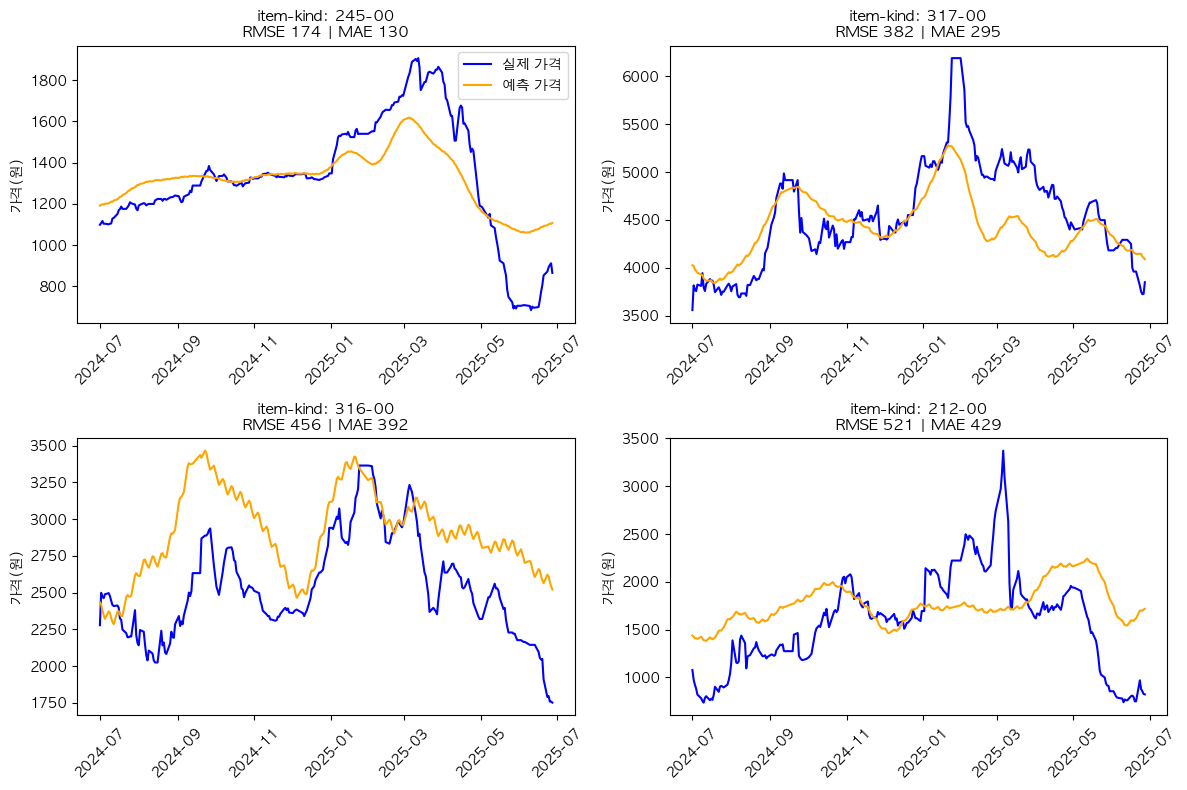

In [ ]:
#  시각화 (가장 우수한 4개만, 2행 2열 배치)
rows = 2
cols = 2
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8), sharex=False)

# 2D 배열 → 1D 배열로 평탄화
axes = axes.flatten()

for ax, 작물 in zip(axes, 상위작물):
    데이터 = 병합데이터[병합데이터['item-kind'] == 작물].sort_values('ds')
    rmse = 성능표.loc[작물, 'RMSE']
    mae = 성능표.loc[작물, 'MAE']

    ax.plot(데이터['ds'], 데이터['실제가격'], label='실제 가격', color='blue')
    ax.plot(데이터['ds'], 데이터['yhat'], label='예측 가격', color='orange')
    ax.set_title(f'item-kind: {작물}\nRMSE {rmse:,.0f} | MAE {mae:,.0f}', fontsize=11)
    ax.set_ylabel("가격(원)")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)

# 범례는 첫 번째 축에만 표시
axes[0].legend()
plt.tight_layout()
plt.show()

/var/folders/18/j3nl8vxd67ndpddr6p5ls4qc0000gn/T/ipykernel_72002/2499447013.py:47: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/18/j3nl8vxd67ndpddr6p5ls4qc0000gn/T/ipykernel_72002/2499447013.py:47: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/18/j3nl8vxd67ndpddr6p5ls4qc0000gn/T/ipykernel_72002/2499447013.py:47: UserWarning: Glyph 51089 (\N{HANGUL SYLLABLE JAG}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/18/j3nl8vxd67ndpddr6p5ls4qc0000gn/T/ipykernel_72002/2499447013.py:47: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from font(s) Arial.
  plt.tight_layout()
/Users/parkdahyeon/miniforge3/envs/spacy_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/parkdahyeon/miniforge3/envs/spacy_

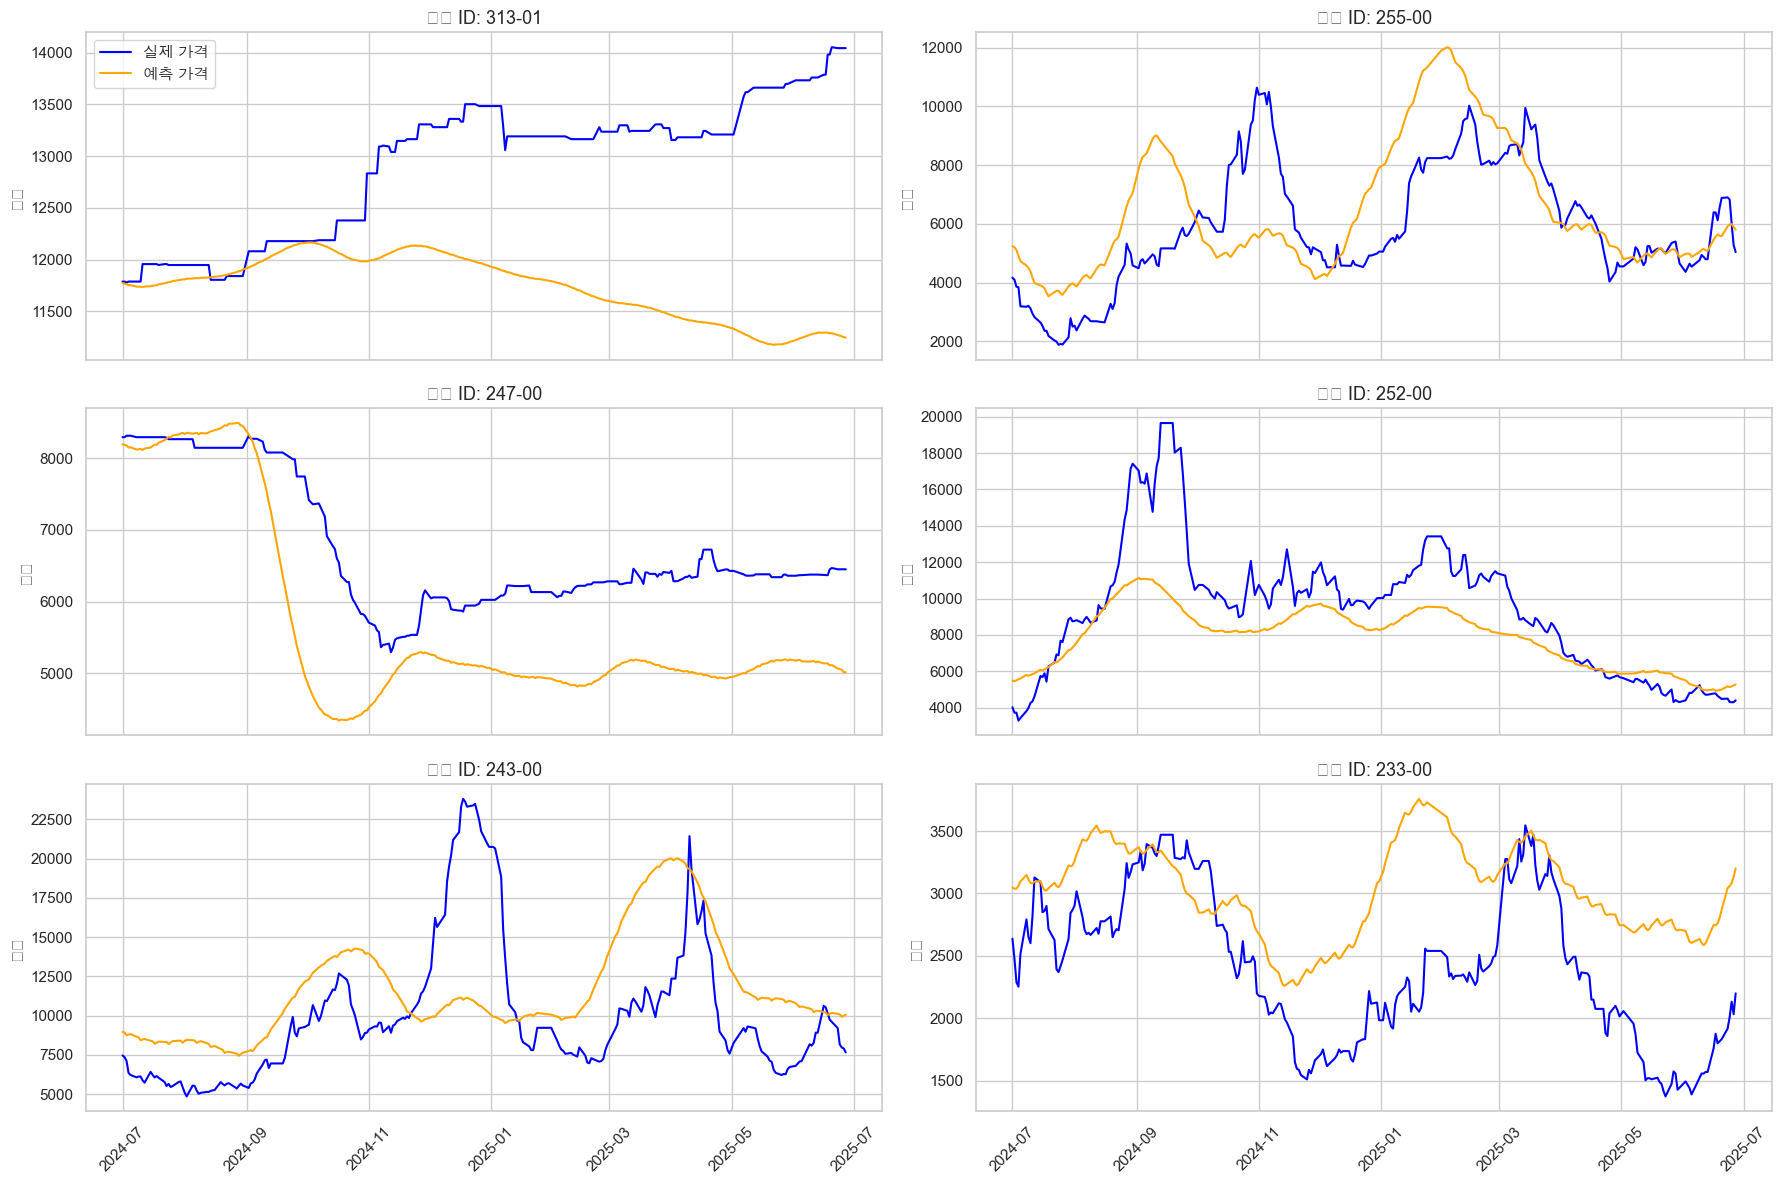

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  

# 예측 결과 불러오기
예측결과 = pd.read_csv("forecast_normal_crops_2024_2025.csv")
예측결과['ds'] = pd.to_datetime(예측결과['ds'])

# 실제 데이터에서 2024년 7월~2025년 6월 범위 추출
실제데이터 = df[(df['date'] >= '2024-07-01') & (df['date'] <= '2025-06-30')]
실제데이터 = 실제데이터[['item-kind', 'date', 'price']].rename(columns={'date': 'ds', 'price': '실제가격'})
실제데이터['ds'] = pd.to_datetime(실제데이터['ds'])

# 실제값과 예측값 병합
병합데이터 = pd.merge(예측결과, 실제데이터, on=['item-kind', 'ds'], how='inner')
병합데이터 = 병합데이터.dropna(subset=['실제가격', 'yhat'])  # 누락 제거

# 자주 등장한 상위 6개 작물만 선택
상위작물 = 병합데이터['item-kind'].value_counts().head(6).index
시각화데이터 = 병합데이터[병합데이터['item-kind'].isin(상위작물)]

# 시각화
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12), sharex=True)
axes = axes.flatten()

for i, 작물 in enumerate(상위작물):
    ax = axes[i]
    데이터 = 시각화데이터[시각화데이터['item-kind'] == 작물]
    ax.plot(데이터['ds'], 데이터['실제가격'], label='실제 가격', color='blue')
    ax.plot(데이터['ds'], 데이터['yhat'], label='예측 가격', color='orange')
    ax.set_title(f'작물 ID: {작물}', fontsize=13)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel("가격")
plt.rcParams['font.family'] = 'AppleGothic'  # 또는 'AppleGothic'

axes[0].legend()
plt.tight_layout()
plt.show()

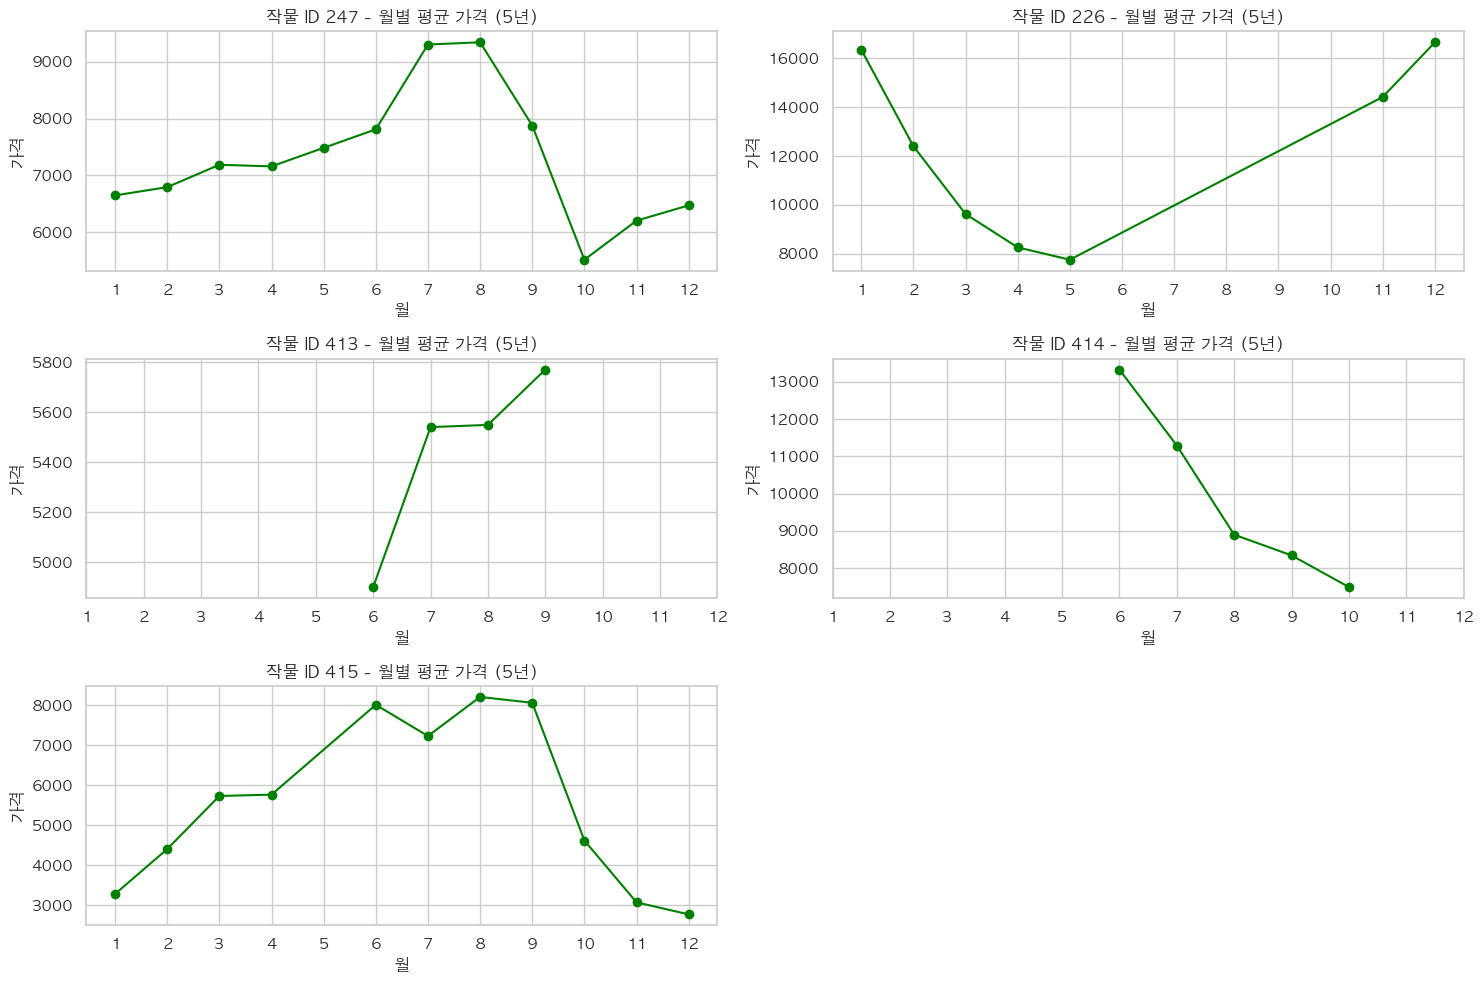

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_pickle("df_2020_2025.pkl")

# 날짜 컬럼이 datetime 형태가 아니면 변환
df['date'] = pd.to_datetime(df['date'])

# 타겟 작물 ID
target_ids = ['247', '226', '413', '414', '415']

# 시작과 종료 날짜
start_date = '2019-07-01'
end_date = '2024-06-30'

# 시각화
plt.figure(figsize=(15, 10))

for idx, item_id in enumerate(target_ids, 1):
    crop_df = df[(df['itemcode'] == item_id) & 
                 (df['date'] >= start_date) & 
                 (df['date'] <= end_date)].copy()
    
    if crop_df.empty:
        continue

    # 월 컬럼 생성 (1~12월만 추출)
    crop_df['month'] = crop_df['date'].dt.month

    # 월별 평균 가격 (년도 무시)
    monthly_avg = crop_df.groupby('month')['price'].mean()

    # 그래프 그리기
    plt.subplot(3, 2, idx)
    plt.plot(monthly_avg.index, monthly_avg.values, marker='o', color='green')
    plt.title(f'작물 ID {item_id} - 월별 평균 가격 (5년)')
    plt.xlabel('월')
    plt.ylabel('가격')
    plt.xticks(range(1, 13))
    plt.grid(True)

plt.tight_layout()
plt.show()

In [41]:
# 247 = [7,8,9]
# 226 = [11, 12, 1]
# 413 = [7,8,9]
# 414 = [6,7,8]
# 415 = [7,8,9]

In [64]:
from prophet import Prophet
import pandas as pd

# 데이터 불러오기
df = pd.read_pickle("df_2020_2025.pkl")

# 특수 작물 ID와 해당 예측할 월 매핑
special_months = {
    247: [7, 8, 9],
    226: [11, 12, 1],
    413: [7, 8, 9],
    414: [6, 7, 8],
    415: [7, 8, 9]
}

forecast_results = {}

for item in df['itemcode'].unique():
    crop_df = df[df['itemcode'] == item].copy()
    
    # 학습 데이터 범위
    crop_df = crop_df[(crop_df['date'] >= '2019-07-01') & (crop_df['date'] <= '2024-06-30')].copy()

    # 특수 작물 처리: 각 연도 상위 3개월만 학습
    if item in special_months:
        crop_df['year'] = crop_df['date'].dt.year
        crop_df['month'] = crop_df['date'].dt.month
        keep_months = []

        for year in range(2019, 2025):
            sub = crop_df[crop_df['year'] == year].copy()
            if len(sub) == 0:
                continue
            monthly_avg = sub.groupby('month')['price'].mean()
            top3 = monthly_avg.sort_values(ascending=False).head(3).index.tolist()
            keep_months += [(year, m) for m in top3]

        crop_df = crop_df[crop_df[['year', 'month']].apply(tuple, axis=1).isin(keep_months)]

    prophet_df = crop_df[['date', 'price']].rename(columns={'date': 'ds', 'price': 'y'})

    if len(prophet_df) < 90:
        continue

    # Prophet 모델 학습
    model = Prophet(yearly_seasonality=True, daily_seasonality=False)
    model.fit(prophet_df)

    # 향후 365일 예측
    future = model.make_future_dataframe(periods=365, freq='D')
    forecast = model.predict(future)

    # 2024-07-01 ~ 2025-06-30 중 필요 기간 필터링
    forecast['month'] = forecast['ds'].dt.month
    forecast['year'] = forecast['ds'].dt.year
    forecast = forecast[(forecast['ds'] >= '2024-07-01') & (forecast['ds'] <= '2025-06-30')]

    # 특수 작물은 지정된 월만 남김
    if item in special_months:
        valid_months = special_months[item]
        forecast = forecast[forecast['month'].isin(valid_months)]

    # 결과 저장
    forecast_results[item] = forecast[['ds', 'yhat']].copy()

# 결과 병합
all_forecasts = pd.concat(forecast_results.values(), keys=forecast_results.keys()).reset_index(level=0).rename(columns={"level_0": "itemcode"})

# 저장
all_forecasts.to_csv("forecast_special_crops_filtered_months.csv", index=False)

21:30:39 - cmdstanpy - INFO - Chain [1] start processing
21:30:39 - cmdstanpy - INFO - Chain [1] done processing
21:30:39 - cmdstanpy - INFO - Chain [1] start processing
21:30:40 - cmdstanpy - INFO - Chain [1] done processing
21:30:40 - cmdstanpy - INFO - Chain [1] start processing
21:30:40 - cmdstanpy - INFO - Chain [1] done processing
21:30:40 - cmdstanpy - INFO - Chain [1] start processing
21:30:40 - cmdstanpy - INFO - Chain [1] done processing
21:30:40 - cmdstanpy - INFO - Chain [1] start processing
21:30:40 - cmdstanpy - INFO - Chain [1] done processing
21:30:40 - cmdstanpy - INFO - Chain [1] start processing
21:30:41 - cmdstanpy - INFO - Chain [1] done processing
21:30:41 - cmdstanpy - INFO - Chain [1] start processing
21:30:41 - cmdstanpy - INFO - Chain [1] done processing
21:30:41 - cmdstanpy - INFO - Chain [1] start processing
21:30:41 - cmdstanpy - INFO - Chain [1] done processing
21:30:41 - cmdstanpy - INFO - Chain [1] start processing
21:30:41 - cmdstanpy - INFO - Chain [1]

In [70]:
forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11183 entries, 0 to 11182
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   itemcode  11183 non-null  int64         
 1   ds        11183 non-null  datetime64[ns]
 2   yhat      11183 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 262.2 KB


In [88]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 🔹 예측 결과 로드
forecast_df = pd.read_csv("forecast_special_crops_filtered_months.csv")
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
forecast_df['itemcode'] = forecast_df['itemcode'].astype(int)  # ✅ 정수형으로 변환

# 🔹 실제 데이터 로드
actual_df = pd.read_pickle("df_2020_2025.pkl")
actual_df = actual_df[(actual_df['date'] >= '2024-07-01') & (actual_df['date'] <= '2025-06-30')]
actual_df['itemcode'] = actual_df['itemcode'].astype(int)
actual_df = actual_df[['date', 'price', 'itemcode']].rename(columns={'date': 'ds'})

# 🔹 병합
merged = pd.merge(forecast_df, actual_df, on=['ds', 'itemcode'], how='inner')

# 🔹 정확도 평가
mae = mean_absolute_error(merged['price'], merged['yhat'])
rmse = mean_squared_error(merged['price'], merged['yhat'])
r2 = r2_score(merged['price'], merged['yhat'])

print(f"📊 특수 작물 예측 성능:")
print(f"- MAE (평균 절대 오차): {mae:.2f}")
print(f"- RMSE (평균 제곱근 오차): {rmse:.2f}")
print(f"- R² (결정계수): {r2:.4f}")

📊 특수 작물 예측 성능:
- MAE (평균 절대 오차): 1201.78
- RMSE (평균 제곱근 오차): 4172352.91
- R² (결정계수): 0.8718


In [7]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from datetime import date
import calendar

# =========================
# 파라미터 (필요시 수정)
# =========================
PATH_PRED = "total_price_by_itemcode_2025_2026.csv"   # 2026 예측 '연간/월선택 합계' 파일 (itemcode별)
PATH_HIST = "df_2020_2025.pkl"                        # 2020~2025 실제 데이터(일 단위 price, date 포함)

# 평균 단가 환산 방식: "auto_by_months" | "days" | "months"
# - auto_by_months: HARVEST_MONTHS에 지정된 월의 '일수 합'으로 나눔(특수작물), 그 외는 365
# - days: 전 작물 365로 나눔
# - months: 전 작물 12로 나눔
PRED_AVG_DENOM = "auto_by_months"

DAYS_2026 = 365
MONTHS_2026 = 12
TARGET_YEAR = 2026

# 상품률(상품으로 판매 가능한 비율, 0~1)
QUALITY_RATE = 0.85

# 수확월(없으면 연중 전월 평균 사용)
HARVEST_MONTHS = {
    247: [7, 8, 9],
    226: [11, 12, 1],
    413: [7, 8, 9],
    414: [6, 7, 8],
    415: [7, 8, 9],
}

# 단수(kg/10a)
YIELD_KG_10A = {
    211: 28912.75575,
    212: 6436.352479,
    213: 4481.130573,
    214: 4095.525292,
    221: 11278.29777,
    222: 4580.320668,
    223: 4078.2824,
    224: 9648.243021,
    225: 5400.15977,
    226: 5599.543539,
    231: 21278.33709,
    232: 2485.54897,
    243: 27165.19824,
    244: 24706.52174,
    245: 17280.80153,
    246: 16568.27134,
    247: 2096.146789,
    252: 1252.920663,
    256: 806.629193,
    257: 1782.954968,
    312: 42,
    313: 120,
    315: 39767,
    316: 76548,
    317: 51782,
    413: 931,
    414: 1389,
}

# 단수 결측치 처리 방식
FILL_YIELD_WITH_MEAN = False  # True면 단수 NaN을 평균으로 대체
AREA_10A = 1.0                # 재배면적(10a 단위)

# =========================
# 0) 유틸: 2026년 특정 월들의 일수 합
# =========================
def days_in_months(year: int, months: list[int]) -> int:
    total = 0
    for m in months:
        # 1~12만 허용 (예: 226의 [11,12,1]처럼 1은 2026년 1월)
        mm = int(m)
        if mm < 1 or mm > 12:
            continue
        total += calendar.monthrange(year, mm)[1]
    return total

# =========================
# 1) 데이터 로드 및 전처리
# =========================
pred_df = pd.read_csv(PATH_PRED).copy()
hist_df = pd.read_pickle(PATH_HIST).copy()

# 히스토리 체크(계절 보정용 원천)
req_cols = {"itemcode", "price", "date"}
missing = req_cols - set(hist_df.columns)
if missing:
    raise ValueError(f"히스토리 데이터에 필요한 컬럼이 없습니다: {missing}")

hist_df["date"] = pd.to_datetime(hist_df["date"], errors="coerce")
hist_df = hist_df.dropna(subset=["date"]).copy()
hist_df["year"] = hist_df["date"].dt.year
hist_df["month"] = hist_df["date"].dt.month
hist_df["itemcode"] = pd.to_numeric(hist_df["itemcode"], errors="coerce").astype("Int64")

pred_df["itemcode"] = pd.to_numeric(pred_df["itemcode"], errors="coerce").astype("Int64")

# 2026 합계 컬럼 자동 탐색 (업데이트된 파일 스키마 대응)
pred_col = None
for c in pred_df.columns:
    cl = str(c).lower()
    if cl in {"pred_sum_2026", "sum_2026", "total_predicted_price", "total_price_2026"}:
        pred_col = c
        break
if pred_col is None:
    raise ValueError("2026 예측 '합계' 컬럼명을 찾지 못했습니다. (예: pred_sum_2026)")

pred_df = pred_df[["itemcode", pred_col]].rename(columns={pred_col: "sum_price_2026"})

# =========================
# 2) (옵션) 계절 보정 계수 계산 준비
# =========================
hist_2020_2024 = hist_df[(hist_df["year"] >= 2020) & (hist_df["year"] <= 2024)].dropna(subset=["itemcode"]).copy()

monthly_avg = (
    hist_2020_2024
    .groupby(["itemcode", "year", "month"], as_index=False)["price"]
    .mean()
    .rename(columns={"price": "monthly_avg_price"})
)
yearly_avg = (
    hist_2020_2024
    .groupby(["itemcode", "year"], as_index=False)["price"]
    .mean()
    .rename(columns={"price": "yearly_avg_price"})
)
tmp = monthly_avg.merge(yearly_avg, on=["itemcode", "year"], how="left")

def harvest_months_for(code: int):
    return HARVEST_MONTHS.get(int(code), None)

def compute_season_coeff(df_grp):
    code = int(df_grp["itemcode"].iloc[0])
    hm = harvest_months_for(code)
    if not hm:
        return pd.Series({"season_coeff": 1.0})
    sel = df_grp[df_grp["month"].isin(hm)]
    year_avg = df_grp["yearly_avg_price"].iloc[0]
    if sel.empty or not pd.notna(year_avg) or year_avg == 0:
        return pd.Series({"season_coeff": 1.0})
    harvest_avg = sel["monthly_avg_price"].mean()
    return pd.Series({"season_coeff": float(harvest_avg / year_avg)})

season_coeff_by_year = (
    tmp.groupby(["itemcode", "year"])
       .apply(compute_season_coeff)
       .reset_index()
)
season_coeff = (
    season_coeff_by_year
    .groupby("itemcode", as_index=False)["season_coeff"]
    .mean()
    .fillna({"season_coeff": 1.0})
)

# =========================
# 3) 2026 '평균 단가(원/kg)' 산출
# =========================
# 분모(denominator) 계산 함수
def denom_for_item(itemcode: int) -> float:
    if PRED_AVG_DENOM == "days":
        return float(DAYS_2026)
    if PRED_AVG_DENOM == "months":
        return float(MONTHS_2026)
    if PRED_AVG_DENOM == "auto_by_months":
        hm = harvest_months_for(itemcode)
        if hm:
            d = days_in_months(TARGET_YEAR, hm)
            # 안전장치
            return float(d if d > 0 else DAYS_2026)
        else:
            return float(DAYS_2026)
    raise ValueError("PRED_AVG_DENOM must be one of: 'auto_by_months', 'days', 'months'.")

pred_df["denom"] = pred_df["itemcode"].astype(int).apply(denom_for_item)
pred_df["avg_price_2026"] = pred_df["sum_price_2026"] / pred_df["denom"]

# 계절보정 적용 여부 결정
# - auto_by_months 모드에서는 이미 '수확월만의 합계 / 해당월 일수'로 수확월 평균단가가 계산되므로 보정 X
if PRED_AVG_DENOM == "auto_by_months":
    pred_df["season_coeff"] = 1.0
else:
    pred_df = pred_df.merge(season_coeff, on="itemcode", how="left")
    pred_df["season_coeff"] = pred_df["season_coeff"].fillna(1.0)

pred_df["harvest_avg_price_2026"] = pred_df["avg_price_2026"] * pred_df["season_coeff"]

# =========================
# 4) 단수(kg/10a) 결합 → 예상 매출(원/10a)
# =========================
yield_df = pd.DataFrame(list(YIELD_KG_10A.items()), columns=["itemcode", "yield_kg_10a"]).astype({"itemcode": "Int64"})
res = pred_df.merge(yield_df, on="itemcode", how="left")

if FILL_YIELD_WITH_MEAN:
    mean_yield = res["yield_kg_10a"].mean(skipna=True)
    res["yield_kg_10a"] = res["yield_kg_10a"].fillna(mean_yield)

res["expected_revenue_2026_per_10a"] = (
    res["harvest_avg_price_2026"] * res["yield_kg_10a"] * QUALITY_RATE * AREA_10A
)

# =========================
# 5) 저장 & 미리보기
# =========================
cols = [
    "itemcode",
    "sum_price_2026",
    "denom",
    "avg_price_2026",
    "season_coeff",
    "harvest_avg_price_2026",
    "yield_kg_10a",
    "expected_revenue_2026_per_10a",
]
out = res[cols].sort_values("expected_revenue_2026_per_10a", ascending=False)

out.to_csv("price_results.csv", index=False, encoding="utf-8-sig")

print("✅ 완료: 예상 매출(원/10a) 계산 및 저장 → price_results.csv")
print("\n상위 12개 미리보기:")
print(out.head(12).to_string(index=False))

✅ 완료: 예상 매출(원/10a) 계산 및 저장 → price_results.csv

상위 12개 미리보기:
 itemcode  sum_price_2026  denom  avg_price_2026  season_coeff  harvest_avg_price_2026  yield_kg_10a  expected_revenue_2026_per_10a
      315       3274071.0  365.0     8970.057534           1.0             8970.057534  39767.000000                   3.032054e+08
      317       1768037.0  365.0     4843.936986           1.0             4843.936986  51782.000000                   2.132044e+08
      243       2935032.0  365.0     8041.183562           1.0             8041.183562  27165.198240                   1.856743e+08
      316        852919.0  365.0     2336.764384           1.0             2336.764384  76548.000000                   1.520434e+08
      244       1546939.0  365.0     4238.189041           1.0             4238.189041  24706.521740                   8.900427e+07
      211        570162.0  365.0     1562.087671           1.0             1562.087671  28912.755750                   3.838962e+07
      231      

/var/folders/18/j3nl8vxd67ndpddr6p5ls4qc0000gn/T/ipykernel_6212/224154844.py:151: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_season_coeff)


In [8]:
from prophet import Prophet
import pandas as pd
import numpy as np
import calendar

# -----------------------------
# 경로/파라미터
# -----------------------------
PATH_DF = "df_2020_2025.pkl"                         # 학습용 원본 데이터
PATH_OUT = "total_price_by_itemcode_2025_2026.csv"   # 업서트 대상 파일 (없으면 생성)
TRAIN_START, TRAIN_END = "2019-07-01", "2024-06-30"
TARGET_START, TARGET_END = "2026-01-01", "2026-12-31"
TARGET_YEAR = 2026

# 특수 작물 및 예측에 반영할 월
special_months = {
    247: [7, 8, 9],
    226: [11, 12, 1],
    413: [7, 8, 9],
    414: [6, 7, 8],
    415: [7, 8, 9],
}

# (옵션) 연도별 상위 3개월만 학습에 사용 여부
USE_TOP3_MONTHS_PER_YEAR_FOR_TRAIN = True

# -----------------------------
# 유틸
# -----------------------------
def days_in_months(year: int, months: list[int]) -> int:
    total = 0
    for m in months:
        mm = int(m)
        if 1 <= mm <= 12:
            total += calendar.monthrange(year, mm)[1]
    return total

# -----------------------------
# 데이터 로드 & 전처리
# -----------------------------
df = pd.read_pickle(PATH_DF).copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])
df["itemcode"] = pd.to_numeric(df["itemcode"], errors="coerce").astype("Int64")

# 학습 범위 필터
train_mask = (df["date"] >= TRAIN_START) & (df["date"] <= TRAIN_END)
df_train_all = df.loc[train_mask, ["itemcode", "date", "price"]].dropna()

# 결과 업서트 대상 파일 읽기(없으면 빈 틀)
try:
    out_df = pd.read_csv(PATH_OUT)
    out_df["itemcode"] = pd.to_numeric(out_df["itemcode"], errors="coerce").astype("Int64")
except FileNotFoundError:
    out_df = pd.DataFrame(columns=["itemcode", "pred_sum_2026", "denom_days_2026"])

# 필요한 컬럼 보강
for col in ["pred_sum_2026", "denom_days_2026"]:
    if col not in out_df.columns:
        out_df[col] = np.nan

# -----------------------------
# 특수 작물별 2026 합계 예측
# -----------------------------
updates = []  # (itemcode, pred_sum_2026, denom_days_2026)

for item in special_months.keys():
    # 해당 작물 학습 데이터
    crop = df_train_all[df_train_all["itemcode"] == item].copy()
    if crop.empty:
        print(f"[SKIP] itemcode {item}: 학습 구간({TRAIN_START}~{TRAIN_END})에 데이터가 없습니다.")
        continue

    # (옵션) 연도별 상위 3개월만 학습
    if USE_TOP3_MONTHS_PER_YEAR_FOR_TRAIN:
        crop["year"] = crop["date"].dt.year
        crop["month"] = crop["date"].dt.month
        keep_months = []
        for yr in range(pd.to_datetime(TRAIN_START).year, pd.to_datetime(TRAIN_END).year + 1):
            sub = crop[crop["year"] == yr]
            if len(sub) == 0:
                continue
            monthly_avg = sub.groupby("month")["price"].mean()
            top3 = monthly_avg.sort_values(ascending=False).head(3).index.tolist()
            keep_months += [(yr, m) for m in top3]
        crop = crop[crop[["year", "month"]].apply(tuple, axis=1).isin(keep_months)].copy()

    # Prophet 학습 데이터
    prophet_df = crop[["date", "price"]].rename(columns={"date": "ds", "price": "y"})
    if len(prophet_df) < 90:
        print(f"[SKIP] itemcode {item}: 학습 표본(>=90) 부족 -> {len(prophet_df)}")
        continue

    # Prophet 학습
    model = Prophet(yearly_seasonality=True, daily_seasonality=False)
    model.fit(prophet_df)

    # 2026년 예측 프레임 (학습 마지막 날짜부터 2026-12-31까지 생성)
    last_train_date = prophet_df["ds"].max()
    periods = (pd.Timestamp(TARGET_END) - last_train_date).days
    if periods <= 0:
        periods = 365  # 안전장치
    future = model.make_future_dataframe(periods=periods, freq="D")
    fcst = model.predict(future)

    # 2026년 구간만 선택
    fcst = fcst[(fcst["ds"] >= TARGET_START) & (fcst["ds"] <= TARGET_END)].copy()
    fcst["month"] = fcst["ds"].dt.month

    # 특수 작물: 지정된 월만 사용
    valid_months = special_months[item]
    fcst = fcst[fcst["month"].isin(valid_months)].copy()

    # 합계 / 분모(일수)
    pred_sum_2026 = float(fcst["yhat"].sum()) if not fcst.empty else np.nan
    denom_days_2026 = days_in_months(TARGET_YEAR, valid_months)

    updates.append((item, pred_sum_2026, denom_days_2026))
    print(f"[OK] itemcode {item}: 2026 합계(월={valid_months}) = {pred_sum_2026 if not np.isnan(pred_sum_2026) else 'NaN'} / 분모일수={denom_days_2026}")

# -----------------------------
# 기존 파일에 업서트(append or update)
# -----------------------------
if updates:
    upd_df = pd.DataFrame(updates, columns=["itemcode", "pred_sum_2026", "denom_days_2026"]).astype({"itemcode": "Int64"})

    # 같은 itemcode는 덮어쓰기
    out_df = out_df[~out_df["itemcode"].isin(upd_df["itemcode"])]
    out_df = pd.concat([out_df, upd_df], ignore_index=True)

    # 정렬 & 저장
    out_df = out_df.sort_values("itemcode").reset_index(drop=True)
    out_df.to_csv(PATH_OUT, index=False)
    print(f"\n✅ 업데이트 완료 → {PATH_OUT}")
    print(out_df[out_df["itemcode"].isin(list(special_months.keys()))].to_string(index=False))
else:
    print("업데이트할 예측 결과가 없습니다.")

13:29:57 - cmdstanpy - INFO - Chain [1] start processing
13:29:57 - cmdstanpy - INFO - Chain [1] done processing
13:29:57 - cmdstanpy - INFO - Chain [1] start processing
13:29:57 - cmdstanpy - INFO - Chain [1] done processing


[OK] itemcode 247: 2026 합계(월=[7, 8, 9]) = 575538.7577436302 / 분모일수=92


13:29:58 - cmdstanpy - INFO - Chain [1] start processing
13:29:58 - cmdstanpy - INFO - Chain [1] done processing
13:29:58 - cmdstanpy - INFO - Chain [1] start processing


[OK] itemcode 226: 2026 합계(월=[11, 12, 1]) = 1900896.7259222546 / 분모일수=92
[OK] itemcode 413: 2026 합계(월=[7, 8, 9]) = 1152219.3898165387 / 분모일수=92


13:29:58 - cmdstanpy - INFO - Chain [1] done processing
13:29:58 - cmdstanpy - INFO - Chain [1] start processing
13:29:58 - cmdstanpy - INFO - Chain [1] done processing


[OK] itemcode 414: 2026 합계(월=[6, 7, 8]) = 932173.635396912 / 분모일수=92
[OK] itemcode 415: 2026 합계(월=[7, 8, 9]) = 1242447.4509893807 / 분모일수=92

✅ 업데이트 완료 → total_price_by_itemcode_2025_2026.csv
 itemcode  total_predicted_price  pred_sum_2026  denom_days_2026
      226                    NaN   1.900897e+06             92.0
      247                    NaN   5.755388e+05             92.0
      413                    NaN   1.152219e+06             92.0
      414                    NaN   9.321736e+05             92.0
      415                    NaN   1.242447e+06             92.0


In [ ]:
import pandas as pd
import numpy as np
import calendar

PATH = "total_price_by_itemcode_2025_2026.csv"

special_months = {
    247: [7, 8, 9],
    226: [11, 12, 1],
    413: [7, 8, 9],
    414: [6, 7, 8],
    415: [7, 8, 9],
}
TARGET_YEAR = 2026

def days_in_months(year, months):
    return int(sum(calendar.monthrange(year, m if 1 <= m <= 12 else 1)[1] 
                   for m in months if 1 <= m <= 12))

# 1) 파일 로드
df = pd.read_csv(PATH)

# 2) itemcode 정수 통일
if "itemcode" in df.columns:
    df["itemcode"] = pd.to_numeric(df["itemcode"], errors="coerce").astype("Int64")

# 3) 두 컬럼 합치기: pred_sum_2026가 있으면 우선 사용, 없으면 total_predicted_price 사용
if "pred_sum_2026" not in df.columns and "total_predicted_price" not in df.columns:
    raise ValueError("pred_sum_2026 또는 total_predicted_price 컬럼이 없습니다.")

df["sum_price_2026"] = (
    df.get("pred_sum_2026", pd.Series(index=df.index, dtype=float))
      .combine_first(df.get("total_predicted_price", pd.Series(index=df.index, dtype=float)))
)

# 4) 분모 컬럼 보강: 특수월이면 해당 월의 2026 ‘일수 합’, 아니면 365
if "denom_days_2026" not in df.columns:
    df["denom_days_2026"] = np.where(
        df["itemcode"].isin(list(special_months.keys())),
        df["itemcode"].map(lambda x: days_in_months(TARGET_YEAR, special_months.get(int(x), []))),
        365,
    ).astype("Int64")

# 5) 불필요 컬럼 정리
drop_cols = [c for c in ["pred_sum_2026", "total_predicted_price"] if c in df.columns]
df.drop(columns=drop_cols, inplace=True)

# 6) 저장
df = df.sort_values("itemcode").reset_index(drop=True)
df.to_csv(PATH, index=False, encoding="utf-8-sig")

print("컬럼 병합 완료 →", PATH)
print(df.head(10).to_string(index=False))

✅ 컬럼 병합 완료 → total_price_by_itemcode_2025_2026.csv
 itemcode  denom_days_2026  sum_price_2026
      211              NaN    5.701620e+05
      212              NaN    6.303370e+05
      213              NaN    2.394102e+06
      214              NaN    2.749004e+06
      221              NaN    8.999310e+05
      222              NaN    1.389034e+06
      223              NaN    1.143180e+06
      224              NaN    7.070050e+05
      225              NaN    1.139821e+06
      226             92.0    1.900897e+06


In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import calendar

# =========================
# 파라미터 (필요시 수정)
# =========================
PATH_PRED = "total_price_by_itemcode_2025_2026.csv"   # 2026 예측 합계 파일 (itemcode별)
PATH_HIST = "df_2020_2025.pkl"                        # 2020~2025 실제 데이터(일 단위 price, date 포함)

# 평균 단가 환산 방식: "auto_by_months" | "days" | "months"
# - auto_by_months: HARVEST_MONTHS에 지정된 월의 '일수 합'으로 나눔(특수작물), 그 외는 365
# - days: 전 작물 365로 나눔
# - months: 전 작물 12로 나눔
PRED_AVG_DENOM = "auto_by_months"

DAYS_2026 = 365
MONTHS_2026 = 12
TARGET_YEAR = 2026

# 상품률(상품으로 판매 가능한 비율, 0~1)
QUALITY_RATE = 0.85

# 수확월(없으면 연중 전월 평균 사용)
HARVEST_MONTHS = {
    247: [7, 8, 9],
    226: [11, 12, 1],
    413: [7, 8, 9],
    414: [6, 7, 8],
    415: [7, 8, 9],
}

# 단수(kg/10a)
YIELD_KG_10A = {
    211: 28912.75575, 212: 6436.352479, 213: 4481.130573, 214: 4095.525292,
    221: 11278.29777, 222: 4580.320668, 223: 4078.2824,   224: 9648.243021,
    225: 5400.15977,  226: 5599.543539, 231: 21278.33709, 232: 2485.54897,
    243: 27165.19824, 244: 24706.52174, 245: 17280.80153, 246: 16568.27134,
    247: 2096.146789, 252: 1252.920663, 256: 806.629193,  257: 1782.954968,
    312: 42,          313: 120,         315: 39767,       316: 76548,
    317: 51782,       413: 931,         414: 1389,
}

# 단수 결측치 처리 방식
FILL_YIELD_WITH_MEAN = False  # True면 단수 NaN을 평균으로 대체
AREA_10A = 1.0                # 재배면적(10a 단위)

# =========================
# 유틸
# =========================
def days_in_months(year: int, months: list[int]) -> int:
    total = 0
    for m in months:
        if 1 <= int(m) <= 12:
            total += calendar.monthrange(year, int(m))[1]
    return total

def harvest_months_for(code: int):
    return HARVEST_MONTHS.get(int(code), None)

# =========================
# 1) 데이터 로드
# =========================
pred_df = pd.read_csv(PATH_PRED).copy()
pred_df["itemcode"] = pd.to_numeric(pred_df["itemcode"], errors="coerce").astype("Int64")

# (히스토리: 계절보정이 필요한 모드에서만 사용)
hist_df = pd.read_pickle(PATH_HIST).copy()
hist_df["date"] = pd.to_datetime(hist_df["date"], errors="coerce")
hist_df = hist_df.dropna(subset=["date"]).copy()
hist_df["year"] = hist_df["date"].dt.year
hist_df["month"] = hist_df["date"].dt.month
hist_df["itemcode"] = pd.to_numeric(hist_df["itemcode"], errors="coerce").astype("Int64")

# =========================
# 2) 2026 합계 컬럼 정규화
#     - sum_price_2026 있으면 그대로 사용
#     - 없으면 pred_sum_2026 / total_predicted_price에서 병합 생성
# =========================
if "sum_price_2026" not in pred_df.columns:
    pred_df["sum_price_2026"] = (
        pred_df.get("pred_sum_2026", pd.Series(index=pred_df.index, dtype=float))
               .combine_first(pred_df.get("total_predicted_price", pd.Series(index=pred_df.index, dtype=float)))
    )

if pred_df["sum_price_2026"].isna().all():
    raise ValueError("sum_price_2026을 구성할 수 없습니다. 입력 파일의 컬럼을 확인하세요.")

# =========================
# 3) 분모(denom) 계산
#     - 파일에 denom_days_2026가 있으면 우선 사용
#     - 없으면 설정(PRED_AVG_DENOM)에 따라 계산
# =========================
if "denom_days_2026" in pred_df.columns and PRED_AVG_DENOM == "auto_by_months":
    pred_df["denom"] = pd.to_numeric(pred_df["denom_days_2026"], errors="coerce")
else:
    def denom_for_item(itemcode: int) -> float:
        if PRED_AVG_DENOM == "days":
            return float(DAYS_2026)
        if PRED_AVG_DENOM == "months":
            return float(MONTHS_2026)
        if PRED_AVG_DENOM == "auto_by_months":
            hm = harvest_months_for(itemcode)
            return float(days_in_months(TARGET_YEAR, hm) if hm else DAYS_2026)
        raise ValueError("PRED_AVG_DENOM must be 'auto_by_months' | 'days' | 'months'")
    pred_df["denom"] = pred_df["itemcode"].astype(int).apply(denom_for_item)

# 평균 단가(원/kg)
pred_df["avg_price_2026"] = pred_df["sum_price_2026"] / pred_df["denom"]

# =========================
# 4) (옵션) 계절 보정 — auto_by_months면 이미 수확월 기준이라 보정 X
# =========================
if PRED_AVG_DENOM == "auto_by_months":
    pred_df["season_coeff"] = 1.0
else:
    # 2020~2024 평균 계절 계수 계산
    hist_2020_2024 = hist_df[(hist_df["year"].between(2020, 2024)) & hist_df["itemcode"].notna()].copy()
    monthly_avg = (
        hist_2020_2024.groupby(["itemcode", "year", "month"], as_index=False)["price"]
                      .mean().rename(columns={"price": "monthly_avg_price"})
    )
    yearly_avg = (
        hist_2020_2024.groupby(["itemcode", "year"], as_index=False)["price"]
                      .mean().rename(columns={"price": "yearly_avg_price"})
    )
    tmp = monthly_avg.merge(yearly_avg, on=["itemcode", "year"], how="left")

    def compute_season_coeff(df_grp):
        code = int(df_grp["itemcode"].iloc[0])
        hm = harvest_months_for(code)
        if not hm:
            return pd.Series({"season_coeff": 1.0})
        sel = df_grp[df_grp["month"].isin(hm)]
        ya = df_grp["yearly_avg_price"].iloc[0]
        if sel.empty or not pd.notna(ya) or ya == 0:
            return pd.Series({"season_coeff": 1.0})
        return pd.Series({"season_coeff": float(sel["monthly_avg_price"].mean() / ya)})

    season_coeff = (
        tmp.groupby(["itemcode", "year"]).apply(compute_season_coeff).reset_index()
           .groupby("itemcode", as_index=False)["season_coeff"].mean()
           .fillna({"season_coeff": 1.0})
    )
    pred_df = pred_df.merge(season_coeff, on="itemcode", how="left")
    pred_df["season_coeff"] = pred_df["season_coeff"].fillna(1.0)

# 수확월 평균 단가
pred_df["harvest_avg_price_2026"] = pred_df["avg_price_2026"] * pred_df["season_coeff"]

# =========================
# 5) 단수(kg/10a) 결합 → 예상 매출(원/10a)
# =========================
yield_df = pd.DataFrame(list(YIELD_KG_10A.items()), columns=["itemcode", "yield_kg_10a"]).astype({"itemcode": "Int64"})
res = pred_df.merge(yield_df, on="itemcode", how="left")

if FILL_YIELD_WITH_MEAN:
    mean_yield = res["yield_kg_10a"].mean(skipna=True)
    res["yield_kg_10a"] = res["yield_kg_10a"].fillna(mean_yield)

res["expected_revenue_2026_per_10a"] = (
    res["harvest_avg_price_2026"] * res["yield_kg_10a"] * QUALITY_RATE * AREA_10A
)

# =========================
# 6) 저장 & 미리보기
# =========================
cols = [
    "itemcode",
    "sum_price_2026",
    "denom",
    "avg_price_2026",
    "season_coeff",
    "harvest_avg_price_2026",
    "yield_kg_10a",
    "expected_revenue_2026_per_10a",
]
out = res[cols].sort_values("expected_revenue_2026_per_10a", ascending=False)

out.to_csv("price_results.csv", index=False, encoding="utf-8-sig")
print("✅ 완료: 예상 매출(원/10a) 계산 및 저장 → price_results.csv")
print("\n상위 12개 미리보기:")
print(out.head(12).to_string(index=False))

/Users/parkdahyeon/miniforge3/envs/spacy_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
13:19:59 - cmdstanpy - INFO - Chain [1] start processing
13:19:59 - cmdstanpy - INFO - Chain [1] done processing
13:20:00 - cmdstanpy - INFO - Chain [1] start processing
13:20:00 - cmdstanpy - INFO - Chain [1] done processing


[OK] itemcode 247: 2026 합계(특정 월만) = 575,538.76


13:20:00 - cmdstanpy - INFO - Chain [1] start processing
13:20:00 - cmdstanpy - INFO - Chain [1] done processing
13:20:00 - cmdstanpy - INFO - Chain [1] start processing


[OK] itemcode 226: 2026 합계(특정 월만) = 1,900,896.73
[OK] itemcode 413: 2026 합계(특정 월만) = 1,152,219.39


13:20:00 - cmdstanpy - INFO - Chain [1] done processing
13:20:00 - cmdstanpy - INFO - Chain [1] start processing
13:20:00 - cmdstanpy - INFO - Chain [1] done processing


[OK] itemcode 414: 2026 합계(특정 월만) = 932,173.64
[OK] itemcode 415: 2026 합계(특정 월만) = 1,242,447.45

✅ 업데이트 완료 → total_price_by_itemcode_2025_2026.csv
 itemcode  total_predicted_price  pred_sum_2026
      226                    NaN   1.900897e+06
      247                    NaN   5.755388e+05
      413                    NaN   1.152219e+06
      414                    NaN   9.321736e+05
      415                    NaN   1.242447e+06


In [ ]:
# -----------------------------
# 평균 가격 계산
# -----------------------------
def calc_avg_price(row):
    item = int(row["itemcode"])
    sum_price = row["sum_price_2026"]

    # 시즌 작물 여부
    if item in HARVEST_MONTHS:
        days = days_in_months(TARGET_YEAR, HARVEST_MONTHS[item])
    else:
        days = 365

    if days > 0:
        return sum_price / days
    else:
        return np.nan

pred_df["avg_price_2026"] = pred_df.apply(calc_avg_price, axis=1)

# -----------------------------
# 단수 결합 & 매출 계산
# -----------------------------
yield_df = pd.DataFrame(list(YIELD_KG_10A.items()),
                        columns=["itemcode", "yield_kg_10a"]).astype({"itemcode": "Int64"})
res = pred_df.merge(yield_df, on="itemcode", how="left")

# 평균가격 × 단수
res["expected_revenue_2026_per_10a"] = res["avg_price_2026"] * res["yield_kg_10a"]

# 저장
cols = ["itemcode", "sum_price_2026", "avg_price_2026", "yield_kg_10a", "expected_revenue_2026_per_10a"]
out = res[cols].sort_values("expected_revenue_2026_per_10a", ascending=False)
out.to_csv("price_results.csv", index=False, encoding="utf-8-sig")

print("✅ 완료 → price_results.csv")
print(out.head(12).to_string(index=False))

✅ 완료: 예상 매출(원/10a) 계산 및 저장 → price_results.csv

상위 12개 미리보기:
 itemcode  sum_price_2026  denom  avg_price_2026  season_coeff  harvest_avg_price_2026  yield_kg_10a  expected_revenue_2026_per_10a
      226    1.900897e+06   92.0    20661.920934           1.0            20661.920934   5599.543539                   9.834273e+07
      414    9.321736e+05   92.0    10132.322124           1.0            10132.322124   1389.000000                   1.196273e+07
      247    5.755388e+05   92.0     6255.856062           1.0             6255.856062   2096.146789                   1.114621e+07
      413    1.152219e+06   92.0    12524.123802           1.0            12524.123802    931.000000                   9.910965e+06
      211    5.701620e+05    NaN             NaN           1.0                     NaN  28912.755750                            NaN
      212    6.303370e+05    NaN             NaN           1.0                     NaN   6436.352479                            NaN
      213    2.

In [13]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import calendar

# -----------------------------
# 경로
# -----------------------------
PATH_PRED = "total_price_by_itemcode_2025_2026.csv"  # sum_price_2026가 있거나, pred_sum_2026/total_predicted_price가 있는 파일
OUT_PATH  = "price_results.csv"
TARGET_YEAR = 2026

# -----------------------------
# 시즌 작물 (딱 이 5개만)
# -----------------------------
HARVEST_MONTHS = {
    247: [7, 8, 9],
    226: [11, 12, 1],   # 1월은 2026년 1월로 계산
    413: [7, 8, 9],
    414: [6, 7, 8],
    415: [7, 8, 9],
}

# -----------------------------
# 단수(kg/10a) — 필요시 값 추가/수정
# -----------------------------
YIELD_KG_10A = {
    211: 28912.75575,  # 배추
    212: 6436.352479,  # 양배추
    213: 4481.130573,  # 시금치
    214: 4095.525292,  # 상추
    221: 11278.29777,  # 수박
    222: 4580.320668,  # 참외
    223: 4078.2824,    # 오이
    224: 9648.243021,  # 호박
    225: 5400.15977,   # 토마토
    226: 5599.543539,  # 딸기
    231: 21278.33709,  # 무
    232: 2485.54897,   # 당근
    233: None,         # 열무 → 단수 정보 없음 (필요시 입력)
    243: 27165.19824,  # 붉은고추
    244: 24706.52174,  # 피마늘
    245: 17280.80153,  # 양파
    246: 16568.27134,  # 파
    247: 2096.146789,  # 생강
    252: 1252.920663,  # 미나리
    253: 3828,         # 깻잎
    255: 5506,         # 피망
    256: 806.629193,   # 파프리카
    257: 1782.954968,  # 멜론
    280: 1001,         # 브로콜리
    312: 42,           # 참깨
    313: 120,          # 들깨
    315: 39767,        # 느타리버섯
    316: 76548,        # 팽이버섯
    317: 51782,        # 새송이버섯
    413: 931,          # 복숭아
    414: 1389,         # 포도
    415: 2976          # 감귤
}

# -----------------------------
# 유틸: 특정 월들의 일수 합
# -----------------------------
def days_in_months(year: int, months: list[int]) -> int:
    total = 0
    for m in months:
        mm = int(m)
        if 1 <= mm <= 12:
            total += calendar.monthrange(year, mm)[1]
    return total

# -----------------------------
# 1) 예측 합계 로드 & sum_price_2026 정리
# -----------------------------
pred_df = pd.read_csv(PATH_PRED).copy()
pred_df["itemcode"] = pd.to_numeric(pred_df["itemcode"], errors="coerce").astype("Int64")

# sum_price_2026 없으면 pred_sum_2026 / total_predicted_price에서 합치기
if "sum_price_2026" not in pred_df.columns:
    pred_df["sum_price_2026"] = (
        pred_df.get("pred_sum_2026", pd.Series(index=pred_df.index, dtype=float))
              .combine_first(pred_df.get("total_predicted_price", pd.Series(index=pred_df.index, dtype=float)))
    )

# 안전 체크
if pred_df["sum_price_2026"].isna().all():
    raise ValueError("sum_price_2026을 구성할 수 없습니다. 입력 파일 컬럼을 확인하세요.")

# -----------------------------
# 2) 평균 가격 계산
#    - 시즌 작물: 수확월 일수 합으로 나눔
#    - 일반 작물: 365로 나눔
# -----------------------------
SEASON_SET = set(HARVEST_MONTHS.keys())

def calc_avg_price(row):
    code = int(row["itemcode"])
    s = row["sum_price_2026"]
    if pd.isna(s):
        return np.nan
    if code in SEASON_SET:
        denom = days_in_months(TARGET_YEAR, HARVEST_MONTHS[code])
        denom = denom if denom > 0 else 365
    else:
        denom = 365
    return s / denom

pred_df["avg_price_2026"] = pred_df.apply(calc_avg_price, axis=1)

# -----------------------------
# 3) 단수 결합 & (평균가격 × 단수) 계산
# -----------------------------
yield_df = pd.DataFrame(list(YIELD_KG_10A.items()),
                        columns=["itemcode", "yield_kg_10a"]).astype({"itemcode": "Int64"})

res = pred_df.merge(yield_df, on="itemcode", how="left")

res["expected_revenue_2026_per_10a"] = res["avg_price_2026"] * res["yield_kg_10a"]

# -----------------------------
# 4) 저장 & 미리보기
# -----------------------------
cols = ["itemcode", "sum_price_2026", "avg_price_2026", "yield_kg_10a", "expected_revenue_2026_per_10a"]
out = res[cols].sort_values("expected_revenue_2026_per_10a", ascending=False)

out.to_csv(OUT_PATH, index=False, encoding="utf-8-sig")
print(f"✅ 완료: 평균가격×단수 계산 → {OUT_PATH}")
print(out.head(12).to_string(index=False))

✅ 완료: 평균가격×단수 계산 → price_results.csv
 itemcode  sum_price_2026  avg_price_2026  yield_kg_10a  expected_revenue_2026_per_10a
      315    3.274071e+06     8970.057534  39767.000000                   3.567123e+08
      317    1.768037e+06     4843.936986  51782.000000                   2.508287e+08
      243    2.935032e+06     8041.183562  27165.198240                   2.184403e+08
      316    8.529190e+05     2336.764384  76548.000000                   1.788746e+08
      226    1.900897e+06    20661.920934   5599.543539                   1.156973e+08
      244    1.546939e+06     4238.189041  24706.521740                   1.047109e+08
      253    5.102351e+06    13979.043836   3828.000000                   5.351178e+07
      211    5.701620e+05     1562.087671  28912.755750                   4.516426e+07
      415    1.242447e+06    13504.863598   2976.000000                   4.019047e+07
      231    6.052690e+05     1658.271233  21278.337090                   3.528525e+07
      